In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


In [2]:
!pip install iterative-stratification

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Adam
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras import layers,regularizers,Sequential,Model,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../input/iterativestratification/iterative_stratification-0.1.6-py3-none-any.whl')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
df = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
non_ctl_idx = df.loc[df['cp_type']!='ctl_vehicle'].index.to_list()
df = df.drop(['sig_id','cp_type','cp_dose','cp_time'],axis=1)
data_X_test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
data_X_test = data_X_test.drop(['sig_id','cp_dose','cp_time'],axis=1)

dada = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
dada = dada.drop('sig_id',axis=1)
df_label = dada.values
df = df.iloc[non_ctl_idx]
df_label = df_label[non_ctl_idx]

In [5]:
cs = df.columns.str.contains('c-')
gs = df.columns.str.contains('g-')

def preprocessor(train,test):
    
    
    n_gs = 2 
    n_cs = 100 
    
    pca_cs = PCA(n_components = n_cs)
    pca_gs = PCA(n_components = n_gs)

    train_pca_gs = pca_gs.fit_transform(train[:,gs])
    train_pca_cs = pca_cs.fit_transform(train[:,cs])
    test_pca_gs = pca_gs.transform(test[:,gs])
    test_pca_cs = pca_cs.transform(test[:,cs])

    
    train_c_mean = train[:,cs].mean(axis=1)
    test_c_mean = test[:,cs].mean(axis=1)
    train_g_mean = train[:,gs].mean(axis=1)
    test_g_mean = test[:,gs].mean(axis=1)
    
    
    train = np.concatenate((train,train_pca_gs,train_pca_cs,train_c_mean[:,np.newaxis]
                            ,train_g_mean[:,np.newaxis]),axis=1)
    test = np.concatenate((test,test_pca_gs,test_pca_cs,test_c_mean[:,np.newaxis],
                           test_g_mean[:,np.newaxis]),axis=1)
    
    scaler = preprocessing.StandardScaler()

    train = scaler.fit_transform(train)

    test = scaler.transform(test)
    
    return train, test

In [6]:
p_min = 0.0005
p_max = 0.9995

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.1, verbose=0,mode='min',
                              patience=3, min_lr=1E-7)
early_st = tf.keras.callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=7, verbose=0, mode='min',
    baseline=None, restore_best_weights=True)

In [8]:
def create_model1(num_columns):
    model = tf.keras.Sequential([
    tf.keras.layers.Input(num_columns),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation="elu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation="elu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation="elu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="elu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),   
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid"))
    ])
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss=losses.BinaryCrossentropy(label_smoothing=0.0015),metrics=logloss
                  )
    return model

In [9]:
def create_model(num_columns):
    model = tf.keras.Sequential([
    tf.keras.layers.Input(num_columns),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5), 
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),        
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid"))
    ])
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss=losses.BinaryCrossentropy(label_smoothing=0.001),metrics=logloss
                  )
    return model

In [10]:
X = 976

from keras import backend 
n_seeds = 6
np.random.seed(1)
seeds = np.random.randint(0,100,size=n_seeds)

n_labels = df_label.shape[1]
n_train = df.shape[0]
n_test = data_X_test.shape[0]
n_folds = 5
y_pred = np.zeros((n_test,n_labels))
oof = tf.constant(0.0)
hists = []


for seed in seeds:
    fold = 0
    print(fold)
    mlkf = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for n,(train, test) in enumerate(mlkf.split(df,df_label)):
        tf.print('OOF score is ',oof)
        print(f'Fold {n}')
        
        
        train_x, validation_x = preprocessor(df.iloc[train].values,
                                       df.iloc[test].values)
        _,data_test = preprocessor(df.iloc[train].values,
                                   data_X_test.drop('cp_type',axis=1).values)

        train_y = df_label[train]
        validation_y = df_label[test]
        
        if seed%2 == 0:
            model = create_model1(X)
        else:    
            model = create_model(X)

        model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001), metrics=logloss )
        

        hist = model.fit(train_x,train_y, batch_size=128, epochs=200,verbose=0,validation_data = (validation_x,validation_y),callbacks =[reduce_lr, early_st])
        hists.append(hist)
        
        # Save Model
        model.save('_seed_'+str(seed)+'_fold_'+str(fold))

        # OOF Score
        y_val = model.predict(validation_x)
        oof += logloss(tf.constant(validation_y,dtype=tf.float32),tf.constant(y_val,dtype=tf.float32))/(n_folds*n_seeds)

        # Run prediction
        y_pred += model.predict(data_test)/(n_folds*n_seeds)
        
        fold += 1
        


0
OOF score is  0
Fold 0
OOF score is  0.000553834
Fold 1
OOF score is  0.00110745686
Fold 2
OOF score is  0.00166536542
Fold 3
OOF score is  0.00223458814
Fold 4
0
OOF score is  0.00279783527
Fold 0
OOF score is  0.00333429105
Fold 1
OOF score is  0.00387598574
Fold 2
OOF score is  0.00442028511
Fold 3
OOF score is  0.0049613486
Fold 4
0
OOF score is  0.00550365122
Fold 0
OOF score is  0.00603992213
Fold 1
OOF score is  0.00657398859
Fold 2
OOF score is  0.00711323321
Fold 3
OOF score is  0.00766387349
Fold 4
0
OOF score is  0.00821010116
Fold 0
OOF score is  0.00876639411
Fold 1
OOF score is  0.00932883471
Fold 2
OOF score is  0.00989156589
Fold 3
OOF score is  0.0104560042
Fold 4
0
OOF score is  0.0110136503
Fold 0
OOF score is  0.0115725799
Fold 1
OOF score is  0.0121246446
Fold 2
OOF score is  0.0126912668
Fold 3
OOF score is  0.0132550094
Fold 4
0
OOF score is  0.0138172545
Fold 0
OOF score is  0.0143761188
Fold 1
OOF score is  0.0149370525
Fold 2
OOF score is  0.0154949203
Fold 

OOF score is  0.0166237075


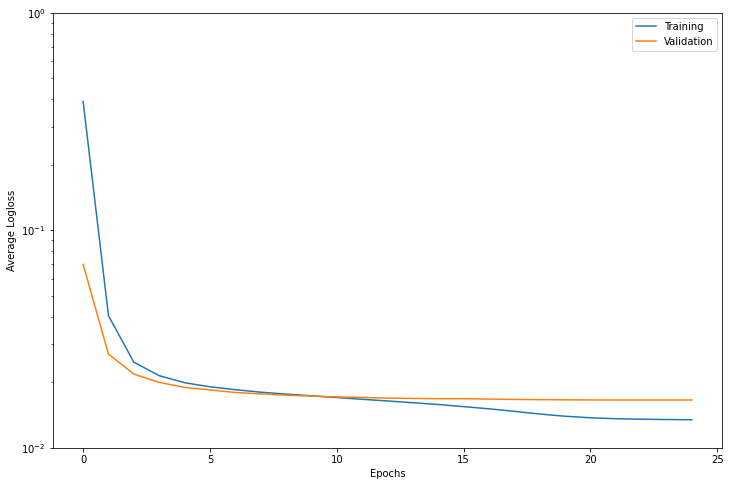

In [11]:
tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.yticks(ticks=[1,1E-1,1E-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [12]:

final = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
final.iloc[:,1:] = np.clip(y_pred,p_min,p_max)
final.iloc[data_X_test['cp_type'] == 'ctl_vehicle',1:] = 0

final.to_csv('submission.csv', index=False)
final.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000924,0.001539,0.001940,0.013589,0.019990,0.006709,0.002946,0.007557,0.000727,...,0.000974,0.001970,0.004295,0.001346,0.000500,0.000851,0.000897,0.002115,0.003758,0.001596
1,id_001897cda,0.000816,0.001919,0.002596,0.004506,0.001908,0.002381,0.005423,0.014096,0.011145,...,0.001526,0.002059,0.004608,0.000500,0.010413,0.001131,0.003740,0.001288,0.007165,0.003007
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001407,0.001154,0.001822,0.009918,0.009919,0.004408,0.002547,0.003313,0.000825,...,0.000735,0.001670,0.002871,0.008561,0.008563,0.000894,0.001880,0.002627,0.001565,0.003220
4,id_0027f1083,0.002081,0.001958,0.002356,0.012263,0.020379,0.004410,0.006995,0.002492,0.000861,...,0.000998,0.001114,0.005403,0.004310,0.001425,0.000919,0.001638,0.002093,0.001077,0.001775
